# Vision Transformer Classification Task

- 기수:

- 이름:

- 작성자: 13기 강승우, 조지성, 한연주

- Reference: 24-2 RNN+Transformer Assignment / 11기 김정우

본 과제에서는 간단한 Vision Transformer 모델을 Scratch 에서부터 구현해보는 내용을 담고 있습니다.

![image.png](attachment:image.png)

## 1. Setting

In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(2025)
torch.manual_seed(2025)

## 2. Training Format

아래 함수는 기본적인 학습 진행을 위한 템플릿입니다.

In [2]:
def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(root='./datasets', train=True, download=True, transform=transform)
    test_set = MNIST(root='./datasets', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 10 ## TODO ##
    LR = 1e-3 ## TODO ##

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()

    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0

        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)

        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

## 3. Forward Process

### 3-1. Patchifying and the linear mapping

기본적으로 하나의 MNIST 데이터는 (1, 28, 28) 으로 구성되어 있습니다.

본 과제에서는 7x7 (49개) 의 patch로 나누는 과정을 진행하게 됩니다.

In [3]:
def patchify(images, n_patches=7):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patch_size = h // n_patches
    patches = torch.zeros(n, n_patches * n_patches, c * patch_size * patch_size) # (N, # patch num, # patch dimension)


    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:,
                              i * patch_size:(i + 1) * patch_size,
                              j * patch_size:(j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches


In [4]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    return patches

In [5]:
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=(1, 28, 28),
    n_patches=7
  )

  x = torch.randn(7, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 49, 16])

torch.Size([7, 49, 16])


이어서 flatten patch에 간단한 linear mapping을 적용해 patch mapping을 진행하고자 합니다.

hidden dimmension은 8차원을 기본으로 하지만, 수정할 수 있습니다.

In [6]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_dim1=8):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden_d = hidden_dim1

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"

    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(self.chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    return tokens

In [7]:
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=(1, 28, 28),
    n_patches=7
  )

  x = torch.randn(7, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 49, 16])

torch.Size([7, 49, 8])


### 3-2. Adding the Classification Token

ViT에선 Transformer Encoder에 같이 v_class 토큰이 입력됩니다.

 (N, 29, 16)에 해당 토큰이 추가되어 (N, 50, 8) 으로 변환되게 됩니다.

In [8]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_dim1=8):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden_d = hidden_dim1

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(self.chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d)) # Classification Token을 정의

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
    return tokens

### 3-3. Positional Encoding

ViT에서의 Positional Encoding은 첫 번째 차원에는 고주파수 값을, 두 번째 차원에는 저주파수 값을 추가합니다. (구체적인 내용은 Attention is All you Need 논문을 참고해주세요!)

각 시퀀스에서 토큰 i에 대해 j 번째 좌표에 다음 값을 추가합니다:

![image.png](attachment:image.png)

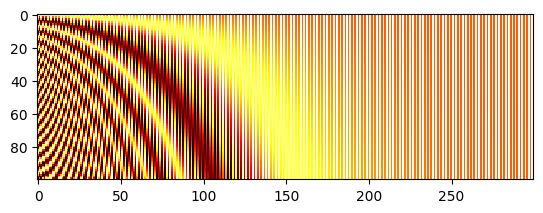

In [9]:
import math
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            if j % 2 == 0:
                result[i][j] = math.sin(i / (10000 ** (j / d)))
            else:
                result[i][j] = math.cos(i / (10000 ** ((j - 1) / d)))
    return result

if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
  plt.show()

해당 부분까지 ViT Class에 더해주게 되면 아래와 같이 진행됩니다.

In [10]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_dim1=8):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden_d = hidden_dim1

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(self.chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d)) # Classification Token을 정의

    # 3) Positional embedding
    self.positional_embeddings = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
    self.positional_embeddings.requires_grad = False

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    # Adding positional embedding
    positional_embeddings = self.positional_embeddings.repeat(images.shape[0], 1, 1)
    out = tokens + positional_embeddings

    return out

### 3-4. Multi-Head Self Attention

MSA를 위한 클래스는 아래와 같이 구현할 수 있습니다.

In [11]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads
        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [12]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [13]:
if __name__ == '__main__':
  model = MyViTBlock(hidden_d=8, n_heads=2)

  x = torch.randn(7, 50, 8)  # Dummy sequences
  print(model(x).shape)      # torch.Size([7, 50, 8])

torch.Size([7, 50, 8])


In [14]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_dim1=8):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden_d = hidden_dim1

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(self.chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d)) # Classification Token을 정의

    # 3) Positional embedding
    self.positional_embeddings = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
    self.positional_embeddings.requires_grad = False

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    # Adding positional embedding
    pos_embed = self.positional_embeddings.repeat(images.shape[0], 1, 1)
    out = tokens + positional_embeddings
    return out

In [15]:
class MyViT(nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7, n_blocks=2, hidden_dim1=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # (C, H, W)
        self.n_patches = n_patches
        self.hidden_d = hidden_dim1
        self.n_blocks = n_blocks
        self.n_heads = n_heads

        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(self.chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classifiation token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d)) # Classification Token을 정의

        # 3) Positional embedding
        self.positional_embeddings = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(self.hidden_d, n_heads) for _ in range(n_blocks)])


def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        return out

최종적으로 Classificaion MLP까지 추가하면 ViT를 완성할 수 있습니다.

In [17]:
class MyViT(nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7, n_blocks=2, hidden_dim1=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # (C, H, W)
        self.n_patches = n_patches
        self.hidden_d = hidden_dim1
        self.n_blocks = n_blocks
        self.n_heads = n_heads

        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(self.chw[0] * (chw[1] / n_patches) * (chw[2] / n_patches))
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classifiation token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d)) # Classification Token을 정의

        # 3) Positional embedding
        self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(self.hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )


    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.pos_embed.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.pos_embed.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)

## 4. Training

적절히 Epoch와 Learning Rate를 수정하여 loss를 최대한 낮춰보세요!

제출 조건: Test ACC를 75 이상 달성하기 :)

In [18]:
from tqdm import tqdm, trange

def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(root='./datasets', train=True, download=True, transform=transform)
    test_set = MNIST(root='./datasets', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    model = MyViT((1, 28, 28)).to(device)
    N_EPOCHS = 15
    LR = 1e-3

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()

    for epoch in range(N_EPOCHS):
        train_loss = 0.0
        model.train()  # 모델을 학습 모드로 설정
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{N_EPOCHS} [Training]", leave=False)

        for batch in progress_bar:
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 현재 진행 상태의 loss를 tqdm에 업데이트
            progress_bar.set_postfix({"train_loss": train_loss})

        print(f"Epoch {epoch + 1}/{N_EPOCHS} train loss: {train_loss:.2f}")

        # Test loop
        model.eval()  # 모델을 평가 모드로 설정
        test_loss = 0.0
        correct, total = 0, 0
        test_progress_bar = tqdm(test_loader, desc=f"Epoch {epoch + 1}/{N_EPOCHS} [Testing]", leave=False)

        with torch.no_grad():
            for batch in test_progress_bar:
                x, y = batch
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                loss = criterion(y_hat, y)
                test_loss += loss.detach().cpu().item() / len(test_loader)

                correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
                total += len(x)

                # 현재 진행 상태의 test loss를 tqdm에 업데이트
                test_progress_bar.set_postfix({"test_loss": test_loss})

        accuracy = correct / total * 100
        print(f"Epoch {epoch + 1}/{N_EPOCHS} test loss: {test_loss:.2f}, test accuracy: {accuracy:.2f}%")


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [20]:
model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_dim1=8, n_heads=2, out_d=10).to(device)

/tmp/ipython-input-894681309.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))


In [21]:
if __name__ == "__main__":
    main()

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.82MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]
/tmp/ipython-input-894681309.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))


Using device:  cuda (Tesla T4)


Epoch 1/15 train loss: 2.18


Epoch 1/15 test loss: 2.07, test accuracy: 37.20%


Epoch 2/15 train loss: 1.98


Epoch 2/15 test loss: 1.89, test accuracy: 58.39%


Epoch 3/15 train loss: 1.84


Epoch 3/15 test loss: 1.81, test accuracy: 65.18%


Epoch 4/15 train loss: 1.80


Epoch 4/15 test loss: 1.79, test accuracy: 67.49%


Epoch 5/15 train loss: 1.78


Epoch 5/15 test loss: 1.76, test accuracy: 70.09%


Epoch 6/15 train loss: 1.73


Epoch 6/15 test loss: 1.69, test accuracy: 77.73%


Epoch 7/15 train loss: 1.68


Epoch 7/15 test loss: 1.65, test accuracy: 81.58%


Epoch 8/15 train loss: 1.64


Epoch 8/15 test loss: 1.63, test accuracy: 83.46%


Epoch 9/15 train loss: 1.63


Epoch 9/15 test loss: 1.62, test accuracy: 84.54%


Epoch 10/15 train loss: 1.62


Epoch 10/15 test loss: 1.61, test accuracy: 84.75%


Epoch 11/15 train loss: 1.61


Epoch 11/15 test loss: 1.61, test accuracy: 85.38%


Epoch 12/15 train loss: 1.61


Epoch 12/15 test loss: 1.60, test accuracy: 85.73%


Epoch 13/15 train loss: 1.60


Epoch 13/15 test loss: 1.59, test accuracy: 86.87%


Epoch 14/15 train loss: 1.60


Epoch 14/15 test loss: 1.63, test accuracy: 82.50%


Epoch 15/15 train loss: 1.60


Epoch 15/15 test loss: 1.60, test accuracy: 86.36%
